Files already downloaded and verified


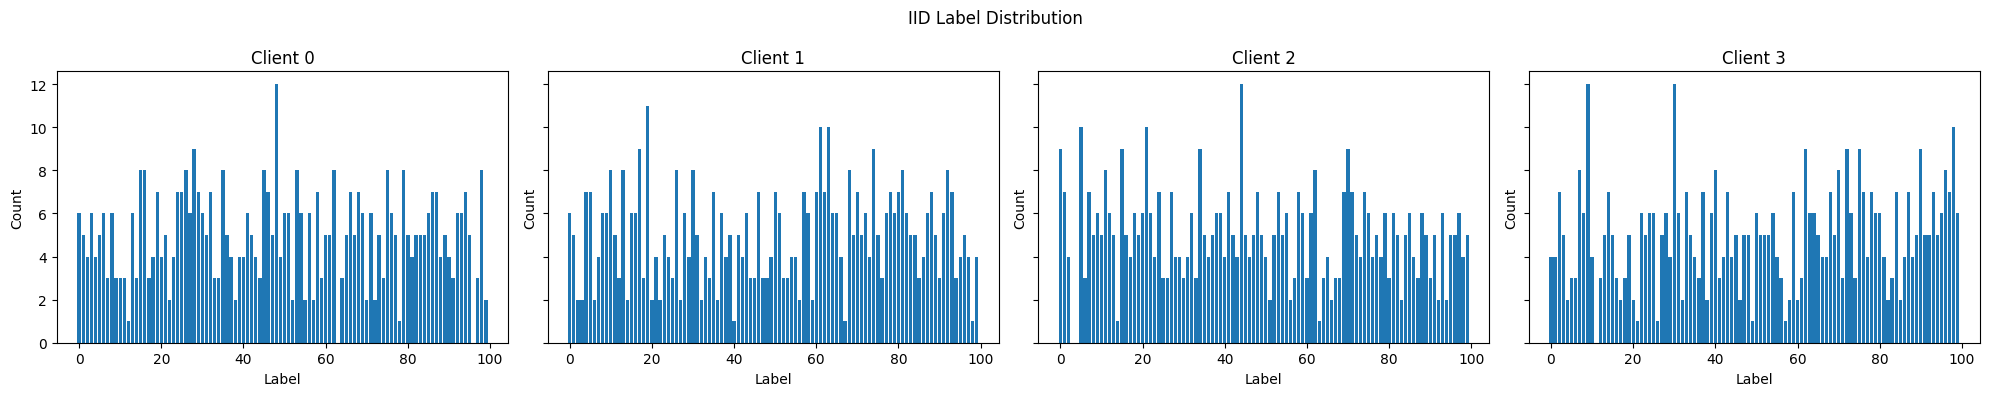

[Non-IID] samples_per_client: 500
[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 157.14it/s]


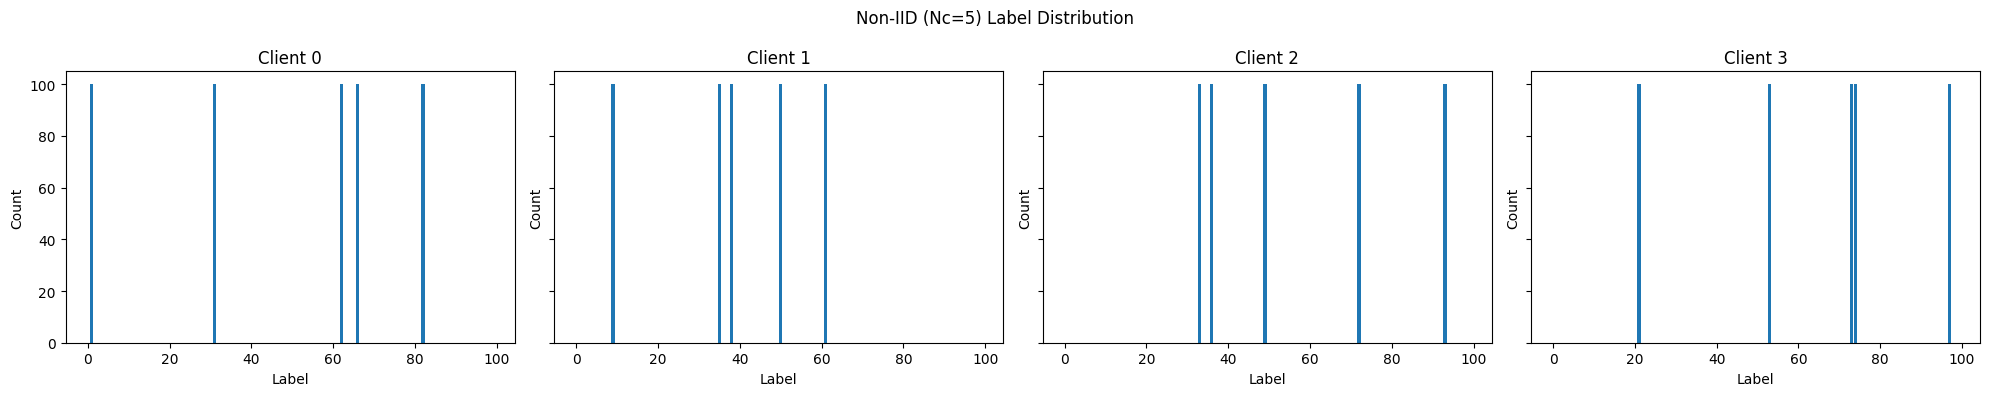

In [1]:
import torch
import pandas as pd
import numpy as np
import random
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

class DatasetSharder:
    """
    Creates IID or Non-IID shards for a dataset.
    Non-IID logic is adapted from your snippet:
      - Sort the dataset by label (for clarity).
      - Use a DataFrame to manage the data.
      - Each client c picks n_labels at random from what's left,
        samples ~samples_per_label from each label, and removes them from the global pool.
      - Some label overlap across clients can happen (since each client picks from the
        remaining labels randomly).
    """

    def __init__(self, dataset, K, shard_type='iid', n_labels=5):
        """
        Args:
            dataset: A PyTorch dataset (e.g. torchvision.datasets.CIFAR100)
            K: Number of clients
            shard_type: 'iid' or 'non_iid'
            n_labels: For non-iid, how many labels each client should pick
        """
        self.dataset = dataset
        self.K = K
        self.shard_type = shard_type
        self.n_labels = n_labels

    def shard_dataset(self):
        """
        Main entry point. Returns a list of K Subset objects, one for each client.
        """
        if self.shard_type == 'iid':
            return self.iid_split()
        elif self.shard_type == 'non_iid':
            return self.non_iid_split()
        else:
            raise ValueError(f"Unsupported shard_type: {self.shard_type}")

    def iid_split(self):
        """
        IID partition:
          - Randomly splits the dataset into K roughly equal parts.
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K

        # Distribute remainder if not perfectly divisible
        lengths = [samples_per_client] * self.K
        remainder = dataset_size - (samples_per_client * self.K)
        for i in range(remainder):
            lengths[i] += 1

        subsets = random_split(self.dataset, lengths)
        return list(subsets)

    def non_iid_split(self):
        """
        Non-IID partition adapted from your snippet:
          - Sort the dataset by label, store in a DataFrame.
          - For each client c:
             1) Randomly picks self.n_labels from the unique labels in the leftover data
             2) For each chosen label, sample ~samples_per_label from that label
             3) Remove those samples from the global DataFrame
          - Allows label overlap across clients if the random choice repeats a label
            (and if there's still leftover samples for that label).
        """
        dataset_size = len(self.dataset)
        samples_per_client = dataset_size // self.K
        print(f"[Non-IID] samples_per_client: {samples_per_client}")

        # Build list of (original_index, (image, label))
        enumerated_data = list(enumerate(self.dataset))
        # Sort by label => enumerated_data[i][1][1] is the label
        enumerated_data.sort(key=lambda x: x[1][1])

        # Convert to DataFrame: columns=[orig_idx, img, targets]
        rows = []
        for (orig_idx, (img, label)) in enumerated_data:
            rows.append((orig_idx, img, label))
        df = pd.DataFrame(rows, columns=["orig_idx", "img", "targets"])

        # ~samples per label for each client
        samples_per_label = samples_per_client // self.n_labels
        print(f"[Non-IID] samples_per_label: {samples_per_label}")

        # If we can't even assign 1 sample per label, raise an error (or handle differently)
        if samples_per_label < 1:
            raise ValueError(
                f"non_iid_split: samples_per_label={samples_per_label} < 1.\n"
                "K or n_labels might be too large for the dataset size."
            )

        clients_subsets = []

        for c in tqdm(range(self.K), desc="Non-IID Splitting"):
            client_rows = []
            # All unique labels left in df
            available_labels = list(df["targets"].unique())
            # Shuffle them and pick n_labels
            np.random.shuffle(available_labels)
            chosen_labels = available_labels[:self.n_labels]

            for label in chosen_labels:
                label_data = df[df["targets"] == label]

                if len(label_data) >= samples_per_label:
                    sampled = label_data.sample(samples_per_label)
                    client_rows.extend(sampled.values.tolist())
                    df = df.drop(sampled.index)

                    # If leftover < samples_per_label, take them all
                    leftover_label_data = df[df["targets"] == label]
                    if len(leftover_label_data) < samples_per_label:
                        client_rows.extend(leftover_label_data.values.tolist())
                        df = df.drop(leftover_label_data.index)
                else:
                    # Not enough data for this label => take it all
                    client_rows.extend(label_data.values.tolist())
                    df = df.drop(label_data.index)

            # Build a Subset from these rows
            client_indices = [row[0] for row in client_rows]  # first column is orig_idx
            subset_for_client = Subset(self.dataset, client_indices)
            clients_subsets.append(subset_for_client)

        return clients_subsets

def plot_label_distribution(client_datasets, num_classes=100, title="Label Distribution", max_clients_to_plot=4):
    """
    Plots the label distribution for up to `max_clients_to_plot` clients.
    Each 'client_datasets[i]' is a Subset of the original dataset.
    """
    num_clients_to_plot = min(len(client_datasets), max_clients_to_plot)
    fig, axes = plt.subplots(1, num_clients_to_plot, figsize=(5 * num_clients_to_plot, 4), sharey=True)
    if num_clients_to_plot == 1:
        axes = [axes]

    for i in range(num_clients_to_plot):
        subset_indices = client_datasets[i].indices
        # Gather labels
        labels = [client_datasets[i].dataset[idx][1] for idx in subset_indices]
        label_counts = [0]*num_classes
        for lab in labels:
            label_counts[lab] += 1

        axes[i].bar(range(num_classes), label_counts)
        axes[i].set_title(f"Client {i}")
        axes[i].set_xlabel("Label")
        axes[i].set_ylabel("Count")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def main():
    # Example: Let's use K=4 just for a quick demonstration
    # (You can set K=100 if you wish, but plotting distribution for 100 clients can be large)
    K = 100
    n_labels = 5  # for non-iid

    # Fix seeds for reproducibility
    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    # Load CIFAR-100 (train set)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
    ])
    trainset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)

    # --------------------------------------------------------------------
    # 1. IID Sharding
    # --------------------------------------------------------------------
    iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='iid')
    iid_client_datasets = iid_sharder.shard_dataset()

    # Plot IID distribution for the first few clients
    plot_label_distribution(
        iid_client_datasets,
        num_classes=100,
        title="IID Label Distribution",
        max_clients_to_plot=4
    )

    # --------------------------------------------------------------------
    # 2. Non-IID Sharding
    # --------------------------------------------------------------------
    non_iid_sharder = DatasetSharder(dataset=trainset, K=K, shard_type='non_iid', n_labels=n_labels)
    non_iid_client_datasets = non_iid_sharder.shard_dataset()

    # Plot Non-IID distribution for the first few clients
    plot_label_distribution(
        non_iid_client_datasets,
        num_classes=100,
        title=f"Non-IID (Nc={n_labels}) Label Distribution",
        max_clients_to_plot=4
    )

if __name__ == "__main__":
    main()


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified

--- Shard config: iid ---


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:11:53, 11.52s/it]

Round 1 => Test Accuracy: 2.77%


Federated Training Rounds:   1%|          | 10/1000 [01:43<2:52:55, 10.48s/it]

Round 10 => Test Accuracy: 13.77%


Federated Training Rounds:   2%|▏         | 20/1000 [03:27<2:52:23, 10.55s/it]

Round 20 => Test Accuracy: 22.52%


Federated Training Rounds:   3%|▎         | 30/1000 [05:11<2:50:09, 10.53s/it]

Round 30 => Test Accuracy: 27.61%


Federated Training Rounds:   4%|▍         | 40/1000 [06:53<2:47:15, 10.45s/it]

Round 40 => Test Accuracy: 31.36%


Federated Training Rounds:   5%|▌         | 50/1000 [08:37<2:47:00, 10.55s/it]

Round 50 => Test Accuracy: 33.37%


Federated Training Rounds:   6%|▌         | 60/1000 [10:21<2:47:35, 10.70s/it]

Round 60 => Test Accuracy: 35.72%


Federated Training Rounds:   7%|▋         | 70/1000 [12:06<2:46:42, 10.76s/it]

Round 70 => Test Accuracy: 37.70%


Federated Training Rounds:   8%|▊         | 80/1000 [13:50<2:43:02, 10.63s/it]

Round 80 => Test Accuracy: 38.71%


Federated Training Rounds:   9%|▉         | 90/1000 [15:32<2:38:53, 10.48s/it]

Round 90 => Test Accuracy: 39.93%


Federated Training Rounds:  10%|█         | 100/1000 [17:15<2:39:24, 10.63s/it]

Round 100 => Test Accuracy: 41.18%


Federated Training Rounds:  11%|█         | 110/1000 [18:56<2:32:59, 10.31s/it]

Round 110 => Test Accuracy: 42.06%


Federated Training Rounds:  12%|█▏        | 120/1000 [20:39<2:34:30, 10.53s/it]

Round 120 => Test Accuracy: 43.21%


Federated Training Rounds:  13%|█▎        | 130/1000 [22:22<2:34:11, 10.63s/it]

Round 130 => Test Accuracy: 43.83%


Federated Training Rounds:  14%|█▍        | 140/1000 [24:04<2:28:09, 10.34s/it]

Round 140 => Test Accuracy: 44.83%


Federated Training Rounds:  15%|█▌        | 150/1000 [25:47<2:29:01, 10.52s/it]

Round 150 => Test Accuracy: 45.66%


Federated Training Rounds:  16%|█▌        | 160/1000 [27:30<2:27:43, 10.55s/it]

Round 160 => Test Accuracy: 46.28%


Federated Training Rounds:  17%|█▋        | 170/1000 [29:14<2:24:20, 10.43s/it]

Round 170 => Test Accuracy: 46.61%


Federated Training Rounds:  18%|█▊        | 180/1000 [30:56<2:21:20, 10.34s/it]

Round 180 => Test Accuracy: 47.40%


Federated Training Rounds:  19%|█▉        | 190/1000 [32:37<2:20:28, 10.41s/it]

Round 190 => Test Accuracy: 47.94%


Federated Training Rounds:  20%|██        | 200/1000 [34:21<2:19:58, 10.50s/it]

Round 200 => Test Accuracy: 48.09%


Federated Training Rounds:  21%|██        | 210/1000 [36:03<2:16:35, 10.37s/it]

Round 210 => Test Accuracy: 48.57%


Federated Training Rounds:  22%|██▏       | 220/1000 [37:46<2:15:52, 10.45s/it]

Round 220 => Test Accuracy: 48.94%


Federated Training Rounds:  23%|██▎       | 230/1000 [39:29<2:14:13, 10.46s/it]

Round 230 => Test Accuracy: 49.37%


Federated Training Rounds:  24%|██▍       | 240/1000 [41:12<2:13:42, 10.56s/it]

Round 240 => Test Accuracy: 49.76%


Federated Training Rounds:  25%|██▌       | 250/1000 [42:54<2:10:24, 10.43s/it]

Round 250 => Test Accuracy: 50.02%


Federated Training Rounds:  26%|██▌       | 260/1000 [44:37<2:11:26, 10.66s/it]

Round 260 => Test Accuracy: 50.57%


Federated Training Rounds:  27%|██▋       | 270/1000 [46:20<2:08:01, 10.52s/it]

Round 270 => Test Accuracy: 49.92%


Federated Training Rounds:  28%|██▊       | 280/1000 [48:04<2:06:25, 10.54s/it]

Round 280 => Test Accuracy: 51.05%


Federated Training Rounds:  29%|██▉       | 290/1000 [49:46<2:03:57, 10.48s/it]

Round 290 => Test Accuracy: 51.38%


Federated Training Rounds:  30%|███       | 300/1000 [51:30<2:02:43, 10.52s/it]

Round 300 => Test Accuracy: 52.00%


Federated Training Rounds:  31%|███       | 310/1000 [53:12<2:02:03, 10.61s/it]

Round 310 => Test Accuracy: 51.21%


Federated Training Rounds:  32%|███▏      | 320/1000 [54:55<1:59:39, 10.56s/it]

Round 320 => Test Accuracy: 52.11%


Federated Training Rounds:  33%|███▎      | 330/1000 [56:38<1:57:03, 10.48s/it]

Round 330 => Test Accuracy: 51.61%


Federated Training Rounds:  34%|███▍      | 340/1000 [58:22<1:56:50, 10.62s/it]

Round 340 => Test Accuracy: 52.54%


Federated Training Rounds:  35%|███▌      | 350/1000 [1:00:05<1:54:54, 10.61s/it]

Round 350 => Test Accuracy: 52.41%


Federated Training Rounds:  36%|███▌      | 360/1000 [1:01:48<1:52:03, 10.51s/it]

Round 360 => Test Accuracy: 52.34%


Federated Training Rounds:  37%|███▋      | 370/1000 [1:03:31<1:49:49, 10.46s/it]

Round 370 => Test Accuracy: 52.62%


Federated Training Rounds:  38%|███▊      | 380/1000 [1:05:16<1:49:13, 10.57s/it]

Round 380 => Test Accuracy: 53.30%


Federated Training Rounds:  39%|███▉      | 390/1000 [1:06:58<1:46:15, 10.45s/it]

Round 390 => Test Accuracy: 53.58%


Federated Training Rounds:  40%|████      | 400/1000 [1:08:40<1:45:12, 10.52s/it]

Round 400 => Test Accuracy: 53.32%


Federated Training Rounds:  41%|████      | 410/1000 [1:10:23<1:43:06, 10.49s/it]

Round 410 => Test Accuracy: 53.59%


Federated Training Rounds:  42%|████▏     | 420/1000 [1:12:06<1:41:24, 10.49s/it]

Round 420 => Test Accuracy: 53.67%


Federated Training Rounds:  43%|████▎     | 430/1000 [1:13:49<1:40:21, 10.56s/it]

Round 430 => Test Accuracy: 53.95%


Federated Training Rounds:  44%|████▍     | 440/1000 [1:15:31<1:37:27, 10.44s/it]

Round 440 => Test Accuracy: 54.01%


Federated Training Rounds:  45%|████▌     | 450/1000 [1:17:12<1:34:43, 10.33s/it]

Round 450 => Test Accuracy: 54.35%


Federated Training Rounds:  46%|████▌     | 460/1000 [1:18:56<1:34:53, 10.54s/it]

Round 460 => Test Accuracy: 54.19%


Federated Training Rounds:  47%|████▋     | 470/1000 [1:20:39<1:33:01, 10.53s/it]

Round 470 => Test Accuracy: 54.06%


Federated Training Rounds:  48%|████▊     | 480/1000 [1:22:21<1:30:51, 10.48s/it]

Round 480 => Test Accuracy: 54.03%


Federated Training Rounds:  49%|████▉     | 490/1000 [1:24:05<1:30:25, 10.64s/it]

Round 490 => Test Accuracy: 54.60%


Federated Training Rounds:  50%|█████     | 500/1000 [1:25:48<1:27:48, 10.54s/it]

Round 500 => Test Accuracy: 54.77%


Federated Training Rounds:  51%|█████     | 510/1000 [1:27:31<1:26:00, 10.53s/it]

Round 510 => Test Accuracy: 53.87%


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:29:14<1:23:11, 10.40s/it]

Round 520 => Test Accuracy: 54.57%


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:30:56<1:22:23, 10.52s/it]

Round 530 => Test Accuracy: 54.58%


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:32:39<1:20:44, 10.53s/it]

Round 540 => Test Accuracy: 54.31%


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:34:22<1:18:58, 10.53s/it]

Round 550 => Test Accuracy: 55.05%


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:36:04<1:16:46, 10.47s/it]

Round 560 => Test Accuracy: 55.00%


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:37:47<1:15:02, 10.47s/it]

Round 570 => Test Accuracy: 55.03%


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:39:29<1:12:55, 10.42s/it]

Round 580 => Test Accuracy: 54.84%


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:41:11<1:11:20, 10.44s/it]

Round 590 => Test Accuracy: 54.68%


Federated Training Rounds:  60%|██████    | 600/1000 [1:42:54<1:09:47, 10.47s/it]

Round 600 => Test Accuracy: 54.87%


Federated Training Rounds:  61%|██████    | 610/1000 [1:44:37<1:08:05, 10.48s/it]

Round 610 => Test Accuracy: 55.24%


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:46:20<1:06:56, 10.57s/it]

Round 620 => Test Accuracy: 55.27%


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:48:01<1:03:38, 10.32s/it]

Round 630 => Test Accuracy: 55.48%


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:49:44<1:02:27, 10.41s/it]

Round 640 => Test Accuracy: 55.06%


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:51:27<1:01:42, 10.58s/it]

Round 650 => Test Accuracy: 55.72%


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:53:11<59:53, 10.57s/it]  

Round 660 => Test Accuracy: 55.60%


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:54:54<57:13, 10.40s/it]

Round 670 => Test Accuracy: 55.65%


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:56:37<56:17, 10.55s/it]

Round 680 => Test Accuracy: 55.75%


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:58:21<54:36, 10.57s/it]

Round 690 => Test Accuracy: 55.93%


Federated Training Rounds:  70%|███████   | 700/1000 [2:00:04<52:22, 10.47s/it]

Round 700 => Test Accuracy: 55.64%


Federated Training Rounds:  71%|███████   | 710/1000 [2:01:47<50:50, 10.52s/it]

Round 710 => Test Accuracy: 55.68%


Federated Training Rounds:  72%|███████▏  | 720/1000 [2:03:29<48:33, 10.40s/it]

Round 720 => Test Accuracy: 55.78%


Federated Training Rounds:  73%|███████▎  | 730/1000 [2:05:12<47:02, 10.45s/it]

Round 730 => Test Accuracy: 56.13%


Federated Training Rounds:  74%|███████▍  | 740/1000 [2:06:54<45:44, 10.55s/it]

Round 740 => Test Accuracy: 55.77%


Federated Training Rounds:  75%|███████▌  | 750/1000 [2:08:38<44:02, 10.57s/it]

Round 750 => Test Accuracy: 55.86%


Federated Training Rounds:  76%|███████▌  | 760/1000 [2:10:21<41:56, 10.48s/it]

Round 760 => Test Accuracy: 55.97%


Federated Training Rounds:  77%|███████▋  | 770/1000 [2:12:04<40:16, 10.51s/it]

Round 770 => Test Accuracy: 55.75%


Federated Training Rounds:  78%|███████▊  | 780/1000 [2:13:47<38:46, 10.58s/it]

Round 780 => Test Accuracy: 55.94%


Federated Training Rounds:  79%|███████▉  | 790/1000 [2:15:30<37:25, 10.69s/it]

Round 790 => Test Accuracy: 56.63%


Federated Training Rounds:  80%|████████  | 800/1000 [2:17:14<34:41, 10.41s/it]

Round 800 => Test Accuracy: 55.91%


Federated Training Rounds:  81%|████████  | 810/1000 [2:18:58<33:32, 10.59s/it]

Round 810 => Test Accuracy: 56.49%


Federated Training Rounds:  82%|████████▏ | 820/1000 [2:20:41<31:30, 10.50s/it]

Round 820 => Test Accuracy: 55.50%


Federated Training Rounds:  83%|████████▎ | 830/1000 [2:22:25<29:56, 10.57s/it]

Round 830 => Test Accuracy: 56.09%


Federated Training Rounds:  84%|████████▍ | 840/1000 [2:24:09<28:25, 10.66s/it]

Round 840 => Test Accuracy: 56.12%


Federated Training Rounds:  85%|████████▌ | 850/1000 [2:25:52<26:01, 10.41s/it]

Round 850 => Test Accuracy: 56.17%


Federated Training Rounds:  86%|████████▌ | 860/1000 [2:27:34<24:13, 10.38s/it]

Round 860 => Test Accuracy: 56.14%


Federated Training Rounds:  87%|████████▋ | 870/1000 [2:29:15<22:18, 10.30s/it]

Round 870 => Test Accuracy: 55.83%


Federated Training Rounds:  88%|████████▊ | 880/1000 [2:30:59<21:07, 10.57s/it]

Round 880 => Test Accuracy: 55.78%


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:32:42<19:16, 10.51s/it]

Round 890 => Test Accuracy: 56.04%


Federated Training Rounds:  90%|█████████ | 900/1000 [2:34:25<17:33, 10.54s/it]

Round 900 => Test Accuracy: 56.43%


Federated Training Rounds:  91%|█████████ | 910/1000 [2:36:07<15:42, 10.47s/it]

Round 910 => Test Accuracy: 56.38%


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:37:51<13:58, 10.48s/it]

Round 920 => Test Accuracy: 56.17%


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:39:34<12:23, 10.62s/it]

Round 930 => Test Accuracy: 56.48%


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:41:17<10:28, 10.48s/it]

Round 940 => Test Accuracy: 55.95%


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:43:01<08:46, 10.53s/it]

Round 950 => Test Accuracy: 56.32%


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:44:43<06:58, 10.47s/it]

Round 960 => Test Accuracy: 56.43%


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:46:25<05:14, 10.47s/it]

Round 970 => Test Accuracy: 56.28%


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:48:09<03:29, 10.50s/it]

Round 980 => Test Accuracy: 56.77%


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:49:54<01:47, 10.76s/it]

Round 990 => Test Accuracy: 56.44%


Federated Training Rounds: 100%|██████████| 1000/1000 [2:51:38<00:00, 10.30s/it]

Round 1000 => Test Accuracy: 56.28%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 500


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 501.43it/s]



--- Shard config: non_iid_1 ---


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:06:03, 11.17s/it]

Round 1 => Test Accuracy: 1.00%


Federated Training Rounds:   1%|          | 10/1000 [01:43<2:52:53, 10.48s/it]

Round 10 => Test Accuracy: 1.01%


Federated Training Rounds:   2%|▏         | 20/1000 [03:27<2:55:52, 10.77s/it]

Round 20 => Test Accuracy: 1.00%


Federated Training Rounds:   3%|▎         | 30/1000 [05:12<2:53:37, 10.74s/it]

Round 30 => Test Accuracy: 1.07%


Federated Training Rounds:   4%|▍         | 40/1000 [06:56<2:47:19, 10.46s/it]

Round 40 => Test Accuracy: 1.00%


Federated Training Rounds:   5%|▌         | 50/1000 [08:39<2:47:23, 10.57s/it]

Round 50 => Test Accuracy: 1.00%


Federated Training Rounds:   6%|▌         | 60/1000 [10:22<2:45:36, 10.57s/it]

Round 60 => Test Accuracy: 1.00%


Federated Training Rounds:   7%|▋         | 70/1000 [12:05<2:43:19, 10.54s/it]

Round 70 => Test Accuracy: 1.00%


Federated Training Rounds:   8%|▊         | 80/1000 [13:49<2:42:48, 10.62s/it]

Round 80 => Test Accuracy: 0.96%


Federated Training Rounds:   9%|▉         | 90/1000 [15:32<2:38:44, 10.47s/it]

Round 90 => Test Accuracy: 1.00%


Federated Training Rounds:  10%|█         | 100/1000 [17:15<2:38:35, 10.57s/it]

Round 100 => Test Accuracy: 1.00%


Federated Training Rounds:  11%|█         | 110/1000 [18:58<2:37:03, 10.59s/it]

Round 110 => Test Accuracy: 1.00%


Federated Training Rounds:  12%|█▏        | 120/1000 [20:41<2:34:17, 10.52s/it]

Round 120 => Test Accuracy: 1.00%


Federated Training Rounds:  13%|█▎        | 130/1000 [22:24<2:34:09, 10.63s/it]

Round 130 => Test Accuracy: 1.08%


Federated Training Rounds:  14%|█▍        | 140/1000 [24:08<2:32:04, 10.61s/it]

Round 140 => Test Accuracy: 1.00%


Federated Training Rounds:  15%|█▌        | 150/1000 [25:52<2:29:42, 10.57s/it]

Round 150 => Test Accuracy: 1.00%


Federated Training Rounds:  16%|█▌        | 160/1000 [27:37<2:29:18, 10.66s/it]

Round 160 => Test Accuracy: 1.00%


Federated Training Rounds:  17%|█▋        | 170/1000 [29:21<2:27:54, 10.69s/it]

Round 170 => Test Accuracy: 1.00%


Federated Training Rounds:  18%|█▊        | 180/1000 [31:04<2:23:21, 10.49s/it]

Round 180 => Test Accuracy: 1.00%


Federated Training Rounds:  19%|█▉        | 190/1000 [32:48<2:23:54, 10.66s/it]

Round 190 => Test Accuracy: 1.00%


Federated Training Rounds:  20%|██        | 200/1000 [34:31<2:19:44, 10.48s/it]

Round 200 => Test Accuracy: 1.00%


Federated Training Rounds:  21%|██        | 210/1000 [36:14<2:19:28, 10.59s/it]

Round 210 => Test Accuracy: 1.00%


Federated Training Rounds:  22%|██▏       | 220/1000 [37:59<2:18:15, 10.64s/it]

Round 220 => Test Accuracy: 1.00%


Federated Training Rounds:  23%|██▎       | 230/1000 [39:43<2:15:33, 10.56s/it]

Round 230 => Test Accuracy: 1.00%


Federated Training Rounds:  24%|██▍       | 240/1000 [41:25<2:14:24, 10.61s/it]

Round 240 => Test Accuracy: 1.00%


Federated Training Rounds:  25%|██▌       | 250/1000 [43:09<2:11:43, 10.54s/it]

Round 250 => Test Accuracy: 1.00%


Federated Training Rounds:  26%|██▌       | 260/1000 [44:51<2:08:57, 10.46s/it]

Round 260 => Test Accuracy: 1.00%


Federated Training Rounds:  27%|██▋       | 270/1000 [46:35<2:09:57, 10.68s/it]

Round 270 => Test Accuracy: 1.00%


Federated Training Rounds:  28%|██▊       | 280/1000 [48:20<2:08:45, 10.73s/it]

Round 280 => Test Accuracy: 1.00%


Federated Training Rounds:  29%|██▉       | 290/1000 [50:03<2:06:19, 10.67s/it]

Round 290 => Test Accuracy: 1.00%


Federated Training Rounds:  30%|███       | 300/1000 [51:46<2:02:13, 10.48s/it]

Round 300 => Test Accuracy: 1.00%


Federated Training Rounds:  31%|███       | 310/1000 [53:30<2:03:10, 10.71s/it]

Round 310 => Test Accuracy: 1.00%


Federated Training Rounds:  32%|███▏      | 320/1000 [55:14<2:01:05, 10.68s/it]

Round 320 => Test Accuracy: 1.00%


Federated Training Rounds:  33%|███▎      | 330/1000 [56:58<1:59:03, 10.66s/it]

Round 330 => Test Accuracy: 1.00%


Federated Training Rounds:  34%|███▍      | 340/1000 [58:41<1:55:50, 10.53s/it]

Round 340 => Test Accuracy: 1.00%


Federated Training Rounds:  35%|███▌      | 350/1000 [1:00:24<1:54:29, 10.57s/it]

Round 350 => Test Accuracy: 1.00%


Federated Training Rounds:  36%|███▌      | 360/1000 [1:02:08<1:52:30, 10.55s/it]

Round 360 => Test Accuracy: 1.00%


Federated Training Rounds:  37%|███▋      | 370/1000 [1:03:51<1:49:00, 10.38s/it]

Round 370 => Test Accuracy: 1.00%


Federated Training Rounds:  38%|███▊      | 380/1000 [1:05:35<1:50:03, 10.65s/it]

Round 380 => Test Accuracy: 1.00%


Federated Training Rounds:  39%|███▉      | 390/1000 [1:07:20<1:50:20, 10.85s/it]

Round 390 => Test Accuracy: 1.00%


Federated Training Rounds:  40%|████      | 400/1000 [1:09:06<1:50:17, 11.03s/it]

Round 400 => Test Accuracy: 1.00%


Federated Training Rounds:  41%|████      | 410/1000 [1:10:53<1:48:05, 10.99s/it]

Round 410 => Test Accuracy: 1.00%


Federated Training Rounds:  42%|████▏     | 420/1000 [1:12:39<1:44:55, 10.86s/it]

Round 420 => Test Accuracy: 1.00%


Federated Training Rounds:  43%|████▎     | 430/1000 [1:14:26<1:42:17, 10.77s/it]

Round 430 => Test Accuracy: 1.00%


Federated Training Rounds:  44%|████▍     | 440/1000 [1:16:12<1:42:00, 10.93s/it]

Round 440 => Test Accuracy: 1.00%


Federated Training Rounds:  45%|████▌     | 450/1000 [1:17:56<1:36:39, 10.55s/it]

Round 450 => Test Accuracy: 1.00%


Federated Training Rounds:  46%|████▌     | 460/1000 [1:19:38<1:34:02, 10.45s/it]

Round 460 => Test Accuracy: 1.00%


Federated Training Rounds:  47%|████▋     | 470/1000 [1:21:22<1:33:46, 10.62s/it]

Round 470 => Test Accuracy: 1.00%


Federated Training Rounds:  48%|████▊     | 480/1000 [1:23:05<1:30:50, 10.48s/it]

Round 480 => Test Accuracy: 1.00%


Federated Training Rounds:  49%|████▉     | 490/1000 [1:24:49<1:30:05, 10.60s/it]

Round 490 => Test Accuracy: 1.00%


Federated Training Rounds:  50%|█████     | 500/1000 [1:26:32<1:28:52, 10.67s/it]

Round 500 => Test Accuracy: 1.00%


Federated Training Rounds:  51%|█████     | 510/1000 [1:28:17<1:27:24, 10.70s/it]

Round 510 => Test Accuracy: 1.00%


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:30:01<1:23:50, 10.48s/it]

Round 520 => Test Accuracy: 1.00%


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:31:45<1:22:06, 10.48s/it]

Round 530 => Test Accuracy: 1.00%


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:33:28<1:21:31, 10.63s/it]

Round 540 => Test Accuracy: 1.00%


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:35:12<1:19:39, 10.62s/it]

Round 550 => Test Accuracy: 1.00%


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:36:54<1:16:34, 10.44s/it]

Round 560 => Test Accuracy: 1.00%


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:38:38<1:15:56, 10.60s/it]

Round 570 => Test Accuracy: 1.00%


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:40:22<1:15:10, 10.74s/it]

Round 580 => Test Accuracy: 1.00%


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:42:06<1:11:50, 10.51s/it]

Round 590 => Test Accuracy: 1.00%


Federated Training Rounds:  60%|██████    | 600/1000 [1:43:48<1:10:24, 10.56s/it]

Round 600 => Test Accuracy: 1.00%


Federated Training Rounds:  61%|██████    | 610/1000 [1:45:32<1:08:52, 10.60s/it]

Round 610 => Test Accuracy: 1.00%


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:47:16<1:07:50, 10.71s/it]

Round 620 => Test Accuracy: 1.00%


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:49:01<1:06:02, 10.71s/it]

Round 630 => Test Accuracy: 1.00%


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:50:46<1:04:05, 10.68s/it]

Round 640 => Test Accuracy: 1.00%


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:52:29<1:01:32, 10.55s/it]

Round 650 => Test Accuracy: 1.00%


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:54:13<59:34, 10.51s/it]  

Round 660 => Test Accuracy: 1.00%


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:55:56<57:45, 10.50s/it]

Round 670 => Test Accuracy: 1.00%


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:57:39<56:53, 10.67s/it]

Round 680 => Test Accuracy: 1.00%


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:59:23<55:04, 10.66s/it]

Round 690 => Test Accuracy: 1.00%


Federated Training Rounds:  70%|███████   | 700/1000 [2:01:08<53:00, 10.60s/it]

Round 700 => Test Accuracy: 1.00%


Federated Training Rounds:  71%|███████   | 710/1000 [2:02:50<50:52, 10.53s/it]

Round 710 => Test Accuracy: 1.00%


Federated Training Rounds:  72%|███████▏  | 720/1000 [2:04:33<49:10, 10.54s/it]

Round 720 => Test Accuracy: 1.00%


Federated Training Rounds:  73%|███████▎  | 730/1000 [2:06:17<47:29, 10.55s/it]

Round 730 => Test Accuracy: 1.00%


Federated Training Rounds:  74%|███████▍  | 740/1000 [2:08:00<45:54, 10.59s/it]

Round 740 => Test Accuracy: 1.00%


Federated Training Rounds:  75%|███████▌  | 750/1000 [2:09:44<44:09, 10.60s/it]

Round 750 => Test Accuracy: 1.00%


Federated Training Rounds:  76%|███████▌  | 760/1000 [2:11:27<42:07, 10.53s/it]

Round 760 => Test Accuracy: 1.00%


Federated Training Rounds:  77%|███████▋  | 770/1000 [2:13:10<40:45, 10.63s/it]

Round 770 => Test Accuracy: 1.00%


Federated Training Rounds:  78%|███████▊  | 780/1000 [2:14:54<39:00, 10.64s/it]

Round 780 => Test Accuracy: 1.00%


Federated Training Rounds:  79%|███████▉  | 790/1000 [2:16:38<37:34, 10.73s/it]

Round 790 => Test Accuracy: 1.00%


Federated Training Rounds:  80%|████████  | 800/1000 [2:18:21<35:03, 10.52s/it]

Round 800 => Test Accuracy: 1.00%


Federated Training Rounds:  81%|████████  | 810/1000 [2:20:06<33:53, 10.70s/it]

Round 810 => Test Accuracy: 1.00%


Federated Training Rounds:  82%|████████▏ | 820/1000 [2:21:50<32:06, 10.71s/it]

Round 820 => Test Accuracy: 1.00%


Federated Training Rounds:  83%|████████▎ | 830/1000 [2:23:36<30:43, 10.85s/it]

Round 830 => Test Accuracy: 1.00%


Federated Training Rounds:  84%|████████▍ | 840/1000 [2:25:19<27:53, 10.46s/it]

Round 840 => Test Accuracy: 1.00%


Federated Training Rounds:  85%|████████▌ | 850/1000 [2:27:03<26:40, 10.67s/it]

Round 850 => Test Accuracy: 1.00%


Federated Training Rounds:  86%|████████▌ | 860/1000 [2:28:48<25:04, 10.75s/it]

Round 860 => Test Accuracy: 1.00%


Federated Training Rounds:  87%|████████▋ | 870/1000 [2:30:31<23:07, 10.67s/it]

Round 870 => Test Accuracy: 1.00%


Federated Training Rounds:  88%|████████▊ | 880/1000 [2:32:16<21:21, 10.68s/it]

Round 880 => Test Accuracy: 1.00%


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:33:59<19:29, 10.63s/it]

Round 890 => Test Accuracy: 1.00%


Federated Training Rounds:  90%|█████████ | 900/1000 [2:35:43<17:30, 10.51s/it]

Round 900 => Test Accuracy: 1.00%


Federated Training Rounds:  91%|█████████ | 910/1000 [2:37:26<15:54, 10.60s/it]

Round 910 => Test Accuracy: 1.00%


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:39:09<13:51, 10.39s/it]

Round 920 => Test Accuracy: 1.00%


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:40:54<12:20, 10.58s/it]

Round 930 => Test Accuracy: 1.00%


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:42:37<10:29, 10.49s/it]

Round 940 => Test Accuracy: 1.00%


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:44:20<08:49, 10.59s/it]

Round 950 => Test Accuracy: 1.00%


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:46:05<07:06, 10.66s/it]

Round 960 => Test Accuracy: 1.00%


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:47:49<05:19, 10.64s/it]

Round 970 => Test Accuracy: 1.00%


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:49:33<03:33, 10.65s/it]

Round 980 => Test Accuracy: 1.00%


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:51:17<01:45, 10.56s/it]

Round 990 => Test Accuracy: 1.00%


Federated Training Rounds: 100%|██████████| 1000/1000 [2:53:00<00:00, 10.38s/it]

Round 1000 => Test Accuracy: 1.00%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 100


Non-IID Splitting: 100%|██████████| 100/100 [00:00<00:00, 119.02it/s]



--- Shard config: non_iid_5 ---


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:14:15, 11.67s/it]

Round 1 => Test Accuracy: 1.47%


Federated Training Rounds:   1%|          | 10/1000 [01:44<2:51:54, 10.42s/it]

Round 10 => Test Accuracy: 4.98%


Federated Training Rounds:   2%|▏         | 20/1000 [03:27<2:52:10, 10.54s/it]

Round 20 => Test Accuracy: 5.16%


Federated Training Rounds:   3%|▎         | 30/1000 [05:12<2:50:45, 10.56s/it]

Round 30 => Test Accuracy: 8.28%


Federated Training Rounds:   4%|▍         | 40/1000 [06:55<2:47:43, 10.48s/it]

Round 40 => Test Accuracy: 8.54%


Federated Training Rounds:   5%|▌         | 50/1000 [08:38<2:44:11, 10.37s/it]

Round 50 => Test Accuracy: 10.05%


Federated Training Rounds:   6%|▌         | 60/1000 [10:22<2:43:32, 10.44s/it]

Round 60 => Test Accuracy: 11.20%


Federated Training Rounds:   7%|▋         | 70/1000 [12:05<2:43:19, 10.54s/it]

Round 70 => Test Accuracy: 13.48%


Federated Training Rounds:   8%|▊         | 80/1000 [13:47<2:39:59, 10.43s/it]

Round 80 => Test Accuracy: 15.12%


Federated Training Rounds:   9%|▉         | 90/1000 [15:29<2:36:56, 10.35s/it]

Round 90 => Test Accuracy: 19.00%


Federated Training Rounds:  10%|█         | 100/1000 [17:13<2:40:11, 10.68s/it]

Round 100 => Test Accuracy: 14.15%


Federated Training Rounds:  11%|█         | 110/1000 [18:56<2:38:39, 10.70s/it]

Round 110 => Test Accuracy: 19.63%


Federated Training Rounds:  12%|█▏        | 120/1000 [20:38<2:33:33, 10.47s/it]

Round 120 => Test Accuracy: 17.81%


Federated Training Rounds:  13%|█▎        | 130/1000 [22:20<2:34:46, 10.67s/it]

Round 130 => Test Accuracy: 19.06%


Federated Training Rounds:  14%|█▍        | 140/1000 [24:04<2:30:06, 10.47s/it]

Round 140 => Test Accuracy: 18.38%


Federated Training Rounds:  15%|█▌        | 150/1000 [25:47<2:29:58, 10.59s/it]

Round 150 => Test Accuracy: 19.32%


Federated Training Rounds:  16%|█▌        | 160/1000 [27:30<2:28:10, 10.58s/it]

Round 160 => Test Accuracy: 20.17%


Federated Training Rounds:  17%|█▋        | 170/1000 [29:13<2:27:22, 10.65s/it]

Round 170 => Test Accuracy: 21.11%


Federated Training Rounds:  18%|█▊        | 180/1000 [30:57<2:26:28, 10.72s/it]

Round 180 => Test Accuracy: 20.60%


Federated Training Rounds:  19%|█▉        | 190/1000 [32:42<2:24:36, 10.71s/it]

Round 190 => Test Accuracy: 20.53%


Federated Training Rounds:  20%|██        | 200/1000 [34:26<2:21:47, 10.63s/it]

Round 200 => Test Accuracy: 22.51%


Federated Training Rounds:  21%|██        | 210/1000 [36:09<2:19:42, 10.61s/it]

Round 210 => Test Accuracy: 22.83%


Federated Training Rounds:  22%|██▏       | 220/1000 [37:54<2:16:45, 10.52s/it]

Round 220 => Test Accuracy: 21.57%


Federated Training Rounds:  23%|██▎       | 230/1000 [39:37<2:13:54, 10.43s/it]

Round 230 => Test Accuracy: 23.65%


Federated Training Rounds:  24%|██▍       | 240/1000 [41:20<2:12:02, 10.42s/it]

Round 240 => Test Accuracy: 23.58%


Federated Training Rounds:  25%|██▌       | 250/1000 [43:01<2:10:33, 10.44s/it]

Round 250 => Test Accuracy: 25.66%


Federated Training Rounds:  26%|██▌       | 260/1000 [44:45<2:10:15, 10.56s/it]

Round 260 => Test Accuracy: 22.45%


Federated Training Rounds:  27%|██▋       | 270/1000 [46:27<2:06:06, 10.36s/it]

Round 270 => Test Accuracy: 25.49%


Federated Training Rounds:  28%|██▊       | 280/1000 [48:10<2:06:08, 10.51s/it]

Round 280 => Test Accuracy: 23.03%


Federated Training Rounds:  29%|██▉       | 290/1000 [49:52<2:04:21, 10.51s/it]

Round 290 => Test Accuracy: 23.14%


Federated Training Rounds:  30%|███       | 300/1000 [51:35<2:01:53, 10.45s/it]

Round 300 => Test Accuracy: 24.28%


Federated Training Rounds:  31%|███       | 310/1000 [53:19<2:01:58, 10.61s/it]

Round 310 => Test Accuracy: 26.35%


Federated Training Rounds:  32%|███▏      | 320/1000 [55:03<2:00:18, 10.61s/it]

Round 320 => Test Accuracy: 21.56%


Federated Training Rounds:  33%|███▎      | 330/1000 [56:48<1:59:04, 10.66s/it]

Round 330 => Test Accuracy: 23.19%


Federated Training Rounds:  34%|███▍      | 340/1000 [58:29<1:54:27, 10.41s/it]

Round 340 => Test Accuracy: 25.48%


Federated Training Rounds:  35%|███▌      | 350/1000 [1:00:13<1:55:00, 10.62s/it]

Round 350 => Test Accuracy: 27.01%


Federated Training Rounds:  36%|███▌      | 360/1000 [1:01:55<1:51:23, 10.44s/it]

Round 360 => Test Accuracy: 25.01%


Federated Training Rounds:  37%|███▋      | 370/1000 [1:03:39<1:50:47, 10.55s/it]

Round 370 => Test Accuracy: 23.69%


Federated Training Rounds:  38%|███▊      | 380/1000 [1:05:22<1:49:44, 10.62s/it]

Round 380 => Test Accuracy: 27.18%


Federated Training Rounds:  39%|███▉      | 390/1000 [1:07:05<1:47:24, 10.57s/it]

Round 390 => Test Accuracy: 26.59%


Federated Training Rounds:  40%|████      | 400/1000 [1:08:49<1:45:26, 10.54s/it]

Round 400 => Test Accuracy: 26.17%


Federated Training Rounds:  41%|████      | 410/1000 [1:10:31<1:42:37, 10.44s/it]

Round 410 => Test Accuracy: 29.91%


Federated Training Rounds:  42%|████▏     | 420/1000 [1:12:14<1:40:12, 10.37s/it]

Round 420 => Test Accuracy: 28.13%


Federated Training Rounds:  43%|████▎     | 430/1000 [1:13:56<1:39:26, 10.47s/it]

Round 430 => Test Accuracy: 30.25%


Federated Training Rounds:  44%|████▍     | 440/1000 [1:15:39<1:37:35, 10.46s/it]

Round 440 => Test Accuracy: 28.52%


Federated Training Rounds:  45%|████▌     | 450/1000 [1:17:21<1:35:40, 10.44s/it]

Round 450 => Test Accuracy: 31.30%


Federated Training Rounds:  46%|████▌     | 460/1000 [1:19:06<1:35:41, 10.63s/it]

Round 460 => Test Accuracy: 27.32%


Federated Training Rounds:  47%|████▋     | 470/1000 [1:20:47<1:31:22, 10.34s/it]

Round 470 => Test Accuracy: 31.43%


Federated Training Rounds:  48%|████▊     | 480/1000 [1:22:31<1:31:14, 10.53s/it]

Round 480 => Test Accuracy: 27.50%


Federated Training Rounds:  49%|████▉     | 490/1000 [1:24:15<1:30:55, 10.70s/it]

Round 490 => Test Accuracy: 29.39%


Federated Training Rounds:  50%|█████     | 500/1000 [1:26:00<1:29:05, 10.69s/it]

Round 500 => Test Accuracy: 26.33%


Federated Training Rounds:  51%|█████     | 510/1000 [1:27:42<1:24:43, 10.38s/it]

Round 510 => Test Accuracy: 30.00%


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:29:25<1:24:18, 10.54s/it]

Round 520 => Test Accuracy: 29.91%


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:31:07<1:21:07, 10.36s/it]

Round 530 => Test Accuracy: 31.01%


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:32:49<1:20:22, 10.48s/it]

Round 540 => Test Accuracy: 31.64%


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:34:32<1:18:45, 10.50s/it]

Round 550 => Test Accuracy: 29.91%


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:36:16<1:16:58, 10.50s/it]

Round 560 => Test Accuracy: 31.29%


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:37:58<1:14:46, 10.43s/it]

Round 570 => Test Accuracy: 31.63%


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:39:41<1:13:27, 10.49s/it]

Round 580 => Test Accuracy: 30.85%


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:41:25<1:12:12, 10.57s/it]

Round 590 => Test Accuracy: 29.05%


Federated Training Rounds:  60%|██████    | 600/1000 [1:43:06<1:08:52, 10.33s/it]

Round 600 => Test Accuracy: 31.48%


Federated Training Rounds:  61%|██████    | 610/1000 [1:44:48<1:08:07, 10.48s/it]

Round 610 => Test Accuracy: 27.69%


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:46:30<1:07:13, 10.62s/it]

Round 620 => Test Accuracy: 30.67%


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:48:12<1:03:19, 10.27s/it]

Round 630 => Test Accuracy: 29.69%


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:49:54<1:02:30, 10.42s/it]

Round 640 => Test Accuracy: 31.67%


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:51:38<1:01:53, 10.61s/it]

Round 650 => Test Accuracy: 28.92%


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:53:21<59:08, 10.44s/it]  

Round 660 => Test Accuracy: 31.79%


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:55:04<57:22, 10.43s/it]

Round 670 => Test Accuracy: 31.16%


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:56:47<55:53, 10.48s/it]

Round 680 => Test Accuracy: 33.74%


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:58:29<54:06, 10.47s/it]

Round 690 => Test Accuracy: 29.01%


Federated Training Rounds:  70%|███████   | 700/1000 [2:00:13<53:31, 10.70s/it]

Round 700 => Test Accuracy: 28.04%


Federated Training Rounds:  71%|███████   | 710/1000 [2:01:55<51:04, 10.57s/it]

Round 710 => Test Accuracy: 30.06%


Federated Training Rounds:  72%|███████▏  | 720/1000 [2:03:38<48:21, 10.36s/it]

Round 720 => Test Accuracy: 30.61%


Federated Training Rounds:  73%|███████▎  | 730/1000 [2:05:21<46:36, 10.36s/it]

Round 730 => Test Accuracy: 31.82%


Federated Training Rounds:  74%|███████▍  | 740/1000 [2:07:03<44:33, 10.28s/it]

Round 740 => Test Accuracy: 31.68%


Federated Training Rounds:  75%|███████▌  | 750/1000 [2:08:46<44:09, 10.60s/it]

Round 750 => Test Accuracy: 29.82%


Federated Training Rounds:  76%|███████▌  | 760/1000 [2:10:28<41:15, 10.31s/it]

Round 760 => Test Accuracy: 28.49%


Federated Training Rounds:  77%|███████▋  | 770/1000 [2:12:11<39:59, 10.43s/it]

Round 770 => Test Accuracy: 33.78%


Federated Training Rounds:  78%|███████▊  | 780/1000 [2:13:54<38:23, 10.47s/it]

Round 780 => Test Accuracy: 27.33%


Federated Training Rounds:  79%|███████▉  | 790/1000 [2:15:35<36:33, 10.45s/it]

Round 790 => Test Accuracy: 30.31%


Federated Training Rounds:  80%|████████  | 800/1000 [2:17:16<34:15, 10.28s/it]

Round 800 => Test Accuracy: 31.01%


Federated Training Rounds:  81%|████████  | 810/1000 [2:18:58<32:54, 10.39s/it]

Round 810 => Test Accuracy: 31.45%


Federated Training Rounds:  82%|████████▏ | 820/1000 [2:20:41<31:01, 10.34s/it]

Round 820 => Test Accuracy: 28.66%


Federated Training Rounds:  83%|████████▎ | 830/1000 [2:22:23<29:39, 10.47s/it]

Round 830 => Test Accuracy: 30.23%


Federated Training Rounds:  84%|████████▍ | 840/1000 [2:24:05<27:26, 10.29s/it]

Round 840 => Test Accuracy: 29.20%


Federated Training Rounds:  85%|████████▌ | 850/1000 [2:25:47<25:59, 10.40s/it]

Round 850 => Test Accuracy: 31.09%


Federated Training Rounds:  86%|████████▌ | 860/1000 [2:27:29<24:09, 10.35s/it]

Round 860 => Test Accuracy: 30.01%


Federated Training Rounds:  87%|████████▋ | 870/1000 [2:29:13<22:57, 10.59s/it]

Round 870 => Test Accuracy: 28.36%


Federated Training Rounds:  88%|████████▊ | 880/1000 [2:30:56<20:54, 10.45s/it]

Round 880 => Test Accuracy: 32.51%


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:32:36<18:45, 10.23s/it]

Round 890 => Test Accuracy: 29.86%


Federated Training Rounds:  90%|█████████ | 900/1000 [2:34:19<17:14, 10.34s/it]

Round 900 => Test Accuracy: 27.02%


Federated Training Rounds:  91%|█████████ | 910/1000 [2:36:02<15:45, 10.51s/it]

Round 910 => Test Accuracy: 32.87%


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:37:45<14:06, 10.58s/it]

Round 920 => Test Accuracy: 33.79%


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:39:29<12:20, 10.58s/it]

Round 930 => Test Accuracy: 32.46%


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:41:12<10:21, 10.36s/it]

Round 940 => Test Accuracy: 33.34%


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:42:54<08:46, 10.53s/it]

Round 950 => Test Accuracy: 31.71%


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:44:37<07:03, 10.59s/it]

Round 960 => Test Accuracy: 29.34%


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:46:18<05:11, 10.39s/it]

Round 970 => Test Accuracy: 32.54%


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:48:01<03:29, 10.45s/it]

Round 980 => Test Accuracy: 31.02%


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:49:44<01:43, 10.36s/it]

Round 990 => Test Accuracy: 34.28%


Federated Training Rounds: 100%|██████████| 1000/1000 [2:51:26<00:00, 10.29s/it]

Round 1000 => Test Accuracy: 30.84%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 50


Non-IID Splitting: 100%|██████████| 100/100 [00:01<00:00, 83.25it/s]



--- Shard config: non_iid_10 ---


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:03:29, 11.02s/it]

Round 1 => Test Accuracy: 2.20%


Federated Training Rounds:   1%|          | 10/1000 [01:43<2:50:58, 10.36s/it]

Round 10 => Test Accuracy: 7.55%


Federated Training Rounds:   2%|▏         | 20/1000 [03:25<2:49:51, 10.40s/it]

Round 20 => Test Accuracy: 10.37%


Federated Training Rounds:   3%|▎         | 30/1000 [05:07<2:48:11, 10.40s/it]

Round 30 => Test Accuracy: 15.36%


Federated Training Rounds:   4%|▍         | 40/1000 [06:48<2:44:10, 10.26s/it]

Round 40 => Test Accuracy: 15.93%


Federated Training Rounds:   5%|▌         | 50/1000 [08:30<2:45:21, 10.44s/it]

Round 50 => Test Accuracy: 19.35%


Federated Training Rounds:   6%|▌         | 60/1000 [10:12<2:43:31, 10.44s/it]

Round 60 => Test Accuracy: 22.01%


Federated Training Rounds:   7%|▋         | 70/1000 [11:54<2:41:05, 10.39s/it]

Round 70 => Test Accuracy: 23.44%


Federated Training Rounds:   8%|▊         | 80/1000 [13:36<2:40:20, 10.46s/it]

Round 80 => Test Accuracy: 23.15%


Federated Training Rounds:   9%|▉         | 90/1000 [15:19<2:39:05, 10.49s/it]

Round 90 => Test Accuracy: 25.21%


Federated Training Rounds:  10%|█         | 100/1000 [16:59<2:33:01, 10.20s/it]

Round 100 => Test Accuracy: 23.99%


Federated Training Rounds:  11%|█         | 110/1000 [18:39<2:31:57, 10.24s/it]

Round 110 => Test Accuracy: 27.05%


Federated Training Rounds:  12%|█▏        | 120/1000 [20:21<2:33:13, 10.45s/it]

Round 120 => Test Accuracy: 26.06%


Federated Training Rounds:  13%|█▎        | 130/1000 [22:03<2:29:53, 10.34s/it]

Round 130 => Test Accuracy: 31.03%


Federated Training Rounds:  14%|█▍        | 140/1000 [23:45<2:27:43, 10.31s/it]

Round 140 => Test Accuracy: 29.13%


Federated Training Rounds:  15%|█▌        | 150/1000 [25:29<2:29:51, 10.58s/it]

Round 150 => Test Accuracy: 30.54%


Federated Training Rounds:  16%|█▌        | 160/1000 [27:10<2:24:49, 10.34s/it]

Round 160 => Test Accuracy: 29.67%


Federated Training Rounds:  17%|█▋        | 170/1000 [28:51<2:25:11, 10.50s/it]

Round 170 => Test Accuracy: 30.91%


Federated Training Rounds:  18%|█▊        | 180/1000 [30:32<2:21:45, 10.37s/it]

Round 180 => Test Accuracy: 30.38%


Federated Training Rounds:  19%|█▉        | 190/1000 [32:14<2:19:41, 10.35s/it]

Round 190 => Test Accuracy: 31.88%


Federated Training Rounds:  20%|██        | 200/1000 [33:57<2:20:46, 10.56s/it]

Round 200 => Test Accuracy: 34.67%


Federated Training Rounds:  21%|██        | 210/1000 [35:38<2:14:31, 10.22s/it]

Round 210 => Test Accuracy: 31.30%


Federated Training Rounds:  22%|██▏       | 220/1000 [37:21<2:17:13, 10.56s/it]

Round 220 => Test Accuracy: 34.66%


Federated Training Rounds:  23%|██▎       | 230/1000 [39:03<2:12:23, 10.32s/it]

Round 230 => Test Accuracy: 34.18%


Federated Training Rounds:  24%|██▍       | 240/1000 [40:45<2:13:14, 10.52s/it]

Round 240 => Test Accuracy: 32.60%


Federated Training Rounds:  25%|██▌       | 250/1000 [42:27<2:10:30, 10.44s/it]

Round 250 => Test Accuracy: 32.93%


Federated Training Rounds:  26%|██▌       | 260/1000 [44:10<2:10:17, 10.56s/it]

Round 260 => Test Accuracy: 37.04%


Federated Training Rounds:  27%|██▋       | 270/1000 [45:52<2:05:12, 10.29s/it]

Round 270 => Test Accuracy: 33.88%


Federated Training Rounds:  28%|██▊       | 280/1000 [47:34<2:03:51, 10.32s/it]

Round 280 => Test Accuracy: 37.47%


Federated Training Rounds:  29%|██▉       | 290/1000 [49:15<2:02:40, 10.37s/it]

Round 290 => Test Accuracy: 34.49%


Federated Training Rounds:  30%|███       | 300/1000 [50:57<2:01:47, 10.44s/it]

Round 300 => Test Accuracy: 35.47%


Federated Training Rounds:  31%|███       | 310/1000 [52:39<2:00:20, 10.46s/it]

Round 310 => Test Accuracy: 35.11%


Federated Training Rounds:  32%|███▏      | 320/1000 [54:22<1:58:18, 10.44s/it]

Round 320 => Test Accuracy: 36.10%


Federated Training Rounds:  33%|███▎      | 330/1000 [56:05<1:58:13, 10.59s/it]

Round 330 => Test Accuracy: 33.50%


Federated Training Rounds:  34%|███▍      | 340/1000 [57:47<1:55:01, 10.46s/it]

Round 340 => Test Accuracy: 36.91%


Federated Training Rounds:  35%|███▌      | 350/1000 [59:30<1:53:48, 10.51s/it]

Round 350 => Test Accuracy: 36.74%


Federated Training Rounds:  36%|███▌      | 360/1000 [1:01:12<1:51:53, 10.49s/it]

Round 360 => Test Accuracy: 32.34%


Federated Training Rounds:  37%|███▋      | 370/1000 [1:02:55<1:47:50, 10.27s/it]

Round 370 => Test Accuracy: 38.10%


Federated Training Rounds:  38%|███▊      | 380/1000 [1:04:37<1:48:44, 10.52s/it]

Round 380 => Test Accuracy: 37.32%


Federated Training Rounds:  39%|███▉      | 390/1000 [1:06:20<1:47:39, 10.59s/it]

Round 390 => Test Accuracy: 38.01%


Federated Training Rounds:  40%|████      | 400/1000 [1:08:02<1:43:16, 10.33s/it]

Round 400 => Test Accuracy: 38.75%


Federated Training Rounds:  41%|████      | 410/1000 [1:09:43<1:42:23, 10.41s/it]

Round 410 => Test Accuracy: 37.24%


Federated Training Rounds:  42%|████▏     | 420/1000 [1:11:26<1:40:21, 10.38s/it]

Round 420 => Test Accuracy: 36.96%


Federated Training Rounds:  43%|████▎     | 430/1000 [1:13:08<1:37:47, 10.29s/it]

Round 430 => Test Accuracy: 38.95%


Federated Training Rounds:  44%|████▍     | 440/1000 [1:14:48<1:36:19, 10.32s/it]

Round 440 => Test Accuracy: 37.93%


Federated Training Rounds:  45%|████▌     | 450/1000 [1:16:29<1:34:02, 10.26s/it]

Round 450 => Test Accuracy: 37.50%


Federated Training Rounds:  46%|████▌     | 460/1000 [1:18:12<1:34:59, 10.56s/it]

Round 460 => Test Accuracy: 39.70%


Federated Training Rounds:  47%|████▋     | 470/1000 [1:19:53<1:32:08, 10.43s/it]

Round 470 => Test Accuracy: 35.57%


Federated Training Rounds:  48%|████▊     | 480/1000 [1:21:34<1:29:39, 10.35s/it]

Round 480 => Test Accuracy: 39.90%


Federated Training Rounds:  49%|████▉     | 490/1000 [1:23:14<1:26:40, 10.20s/it]

Round 490 => Test Accuracy: 39.18%


Federated Training Rounds:  50%|█████     | 500/1000 [1:24:56<1:26:53, 10.43s/it]

Round 500 => Test Accuracy: 37.08%


Federated Training Rounds:  51%|█████     | 510/1000 [1:26:39<1:26:01, 10.53s/it]

Round 510 => Test Accuracy: 38.49%


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:28:21<1:23:18, 10.41s/it]

Round 520 => Test Accuracy: 37.92%


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:30:02<1:20:39, 10.30s/it]

Round 530 => Test Accuracy: 39.77%


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:31:43<1:19:20, 10.35s/it]

Round 540 => Test Accuracy: 38.98%


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:33:23<1:15:38, 10.09s/it]

Round 550 => Test Accuracy: 37.59%


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:35:05<1:16:19, 10.41s/it]

Round 560 => Test Accuracy: 39.81%


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:36:45<1:13:07, 10.20s/it]

Round 570 => Test Accuracy: 39.75%


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:38:28<1:13:00, 10.43s/it]

Round 580 => Test Accuracy: 36.84%


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:40:10<1:11:25, 10.45s/it]

Round 590 => Test Accuracy: 40.44%


Federated Training Rounds:  60%|██████    | 600/1000 [1:41:54<1:10:06, 10.52s/it]

Round 600 => Test Accuracy: 39.59%


Federated Training Rounds:  61%|██████    | 610/1000 [1:43:37<1:08:01, 10.46s/it]

Round 610 => Test Accuracy: 40.44%


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:45:18<1:05:26, 10.33s/it]

Round 620 => Test Accuracy: 37.92%


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:47:00<1:03:58, 10.37s/it]

Round 630 => Test Accuracy: 39.44%


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:48:45<1:05:05, 10.85s/it]

Round 640 => Test Accuracy: 42.15%


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:50:27<1:01:28, 10.54s/it]

Round 650 => Test Accuracy: 40.93%


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:52:08<59:16, 10.46s/it]  

Round 660 => Test Accuracy: 39.62%


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:53:50<57:01, 10.37s/it]

Round 670 => Test Accuracy: 39.62%


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:55:31<55:00, 10.31s/it]

Round 680 => Test Accuracy: 40.06%


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:57:12<53:24, 10.34s/it]

Round 690 => Test Accuracy: 41.07%


Federated Training Rounds:  70%|███████   | 700/1000 [1:58:55<51:55, 10.39s/it]

Round 700 => Test Accuracy: 41.12%


Federated Training Rounds:  71%|███████   | 710/1000 [2:00:36<50:07, 10.37s/it]

Round 710 => Test Accuracy: 41.87%


Federated Training Rounds:  72%|███████▏  | 720/1000 [2:02:19<49:26, 10.59s/it]

Round 720 => Test Accuracy: 41.93%


Federated Training Rounds:  73%|███████▎  | 730/1000 [2:04:00<47:16, 10.50s/it]

Round 730 => Test Accuracy: 38.97%


Federated Training Rounds:  74%|███████▍  | 740/1000 [2:05:41<44:54, 10.36s/it]

Round 740 => Test Accuracy: 40.54%


Federated Training Rounds:  75%|███████▌  | 750/1000 [2:07:24<43:38, 10.47s/it]

Round 750 => Test Accuracy: 42.28%


Federated Training Rounds:  76%|███████▌  | 760/1000 [2:09:06<41:16, 10.32s/it]

Round 760 => Test Accuracy: 41.20%


Federated Training Rounds:  77%|███████▋  | 770/1000 [2:10:46<39:05, 10.20s/it]

Round 770 => Test Accuracy: 40.76%


Federated Training Rounds:  78%|███████▊  | 780/1000 [2:12:27<37:34, 10.25s/it]

Round 780 => Test Accuracy: 40.26%


Federated Training Rounds:  79%|███████▉  | 790/1000 [2:14:08<35:54, 10.26s/it]

Round 790 => Test Accuracy: 40.49%


Federated Training Rounds:  80%|████████  | 800/1000 [2:15:49<34:26, 10.33s/it]

Round 800 => Test Accuracy: 42.94%


Federated Training Rounds:  81%|████████  | 810/1000 [2:17:30<32:52, 10.38s/it]

Round 810 => Test Accuracy: 40.53%


Federated Training Rounds:  82%|████████▏ | 820/1000 [2:19:12<31:14, 10.41s/it]

Round 820 => Test Accuracy: 39.10%


Federated Training Rounds:  83%|████████▎ | 830/1000 [2:20:54<29:31, 10.42s/it]

Round 830 => Test Accuracy: 40.68%


Federated Training Rounds:  84%|████████▍ | 840/1000 [2:22:36<27:25, 10.29s/it]

Round 840 => Test Accuracy: 41.44%


Federated Training Rounds:  85%|████████▌ | 850/1000 [2:24:16<25:26, 10.18s/it]

Round 850 => Test Accuracy: 39.65%


Federated Training Rounds:  86%|████████▌ | 860/1000 [2:25:59<24:34, 10.53s/it]

Round 860 => Test Accuracy: 43.31%


Federated Training Rounds:  87%|████████▋ | 870/1000 [2:27:41<22:35, 10.43s/it]

Round 870 => Test Accuracy: 41.92%


Federated Training Rounds:  88%|████████▊ | 880/1000 [2:29:23<20:34, 10.29s/it]

Round 880 => Test Accuracy: 42.52%


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:31:04<18:58, 10.35s/it]

Round 890 => Test Accuracy: 38.78%


Federated Training Rounds:  90%|█████████ | 900/1000 [2:32:46<17:17, 10.38s/it]

Round 900 => Test Accuracy: 40.19%


Federated Training Rounds:  91%|█████████ | 910/1000 [2:34:28<15:34, 10.38s/it]

Round 910 => Test Accuracy: 42.83%


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:36:09<13:46, 10.33s/it]

Round 920 => Test Accuracy: 42.57%


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:37:51<12:09, 10.42s/it]

Round 930 => Test Accuracy: 41.13%


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:39:32<10:17, 10.29s/it]

Round 940 => Test Accuracy: 43.32%


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:41:14<08:36, 10.34s/it]

Round 950 => Test Accuracy: 40.66%


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:42:57<06:59, 10.49s/it]

Round 960 => Test Accuracy: 39.72%


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:44:39<05:08, 10.29s/it]

Round 970 => Test Accuracy: 41.89%


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:46:21<03:26, 10.34s/it]

Round 980 => Test Accuracy: 42.20%


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:48:02<01:45, 10.51s/it]

Round 990 => Test Accuracy: 44.01%


Federated Training Rounds: 100%|██████████| 1000/1000 [2:49:47<00:00, 10.19s/it]

Round 1000 => Test Accuracy: 41.05%
[Non-IID] samples_per_client: 500


[Non-IID] samples_per_label: 10


Non-IID Splitting: 100%|██████████| 100/100 [00:05<00:00, 17.18it/s]



--- Shard config: non_iid_50 ---


Federated Training Rounds:   0%|          | 1/1000 [00:11<3:03:40, 11.03s/it]

Round 1 => Test Accuracy: 3.23%


Federated Training Rounds:   1%|          | 10/1000 [01:43<2:52:17, 10.44s/it]

Round 10 => Test Accuracy: 11.73%


Federated Training Rounds:   2%|▏         | 20/1000 [03:25<2:49:48, 10.40s/it]

Round 20 => Test Accuracy: 18.51%


Federated Training Rounds:   3%|▎         | 30/1000 [05:07<2:46:56, 10.33s/it]

Round 30 => Test Accuracy: 24.37%


Federated Training Rounds:   4%|▍         | 40/1000 [06:48<2:47:01, 10.44s/it]

Round 40 => Test Accuracy: 25.86%


Federated Training Rounds:   5%|▌         | 50/1000 [08:31<2:45:03, 10.42s/it]

Round 50 => Test Accuracy: 26.44%


Federated Training Rounds:   6%|▌         | 60/1000 [10:13<2:42:18, 10.36s/it]

Round 60 => Test Accuracy: 31.73%


Federated Training Rounds:   7%|▋         | 70/1000 [11:54<2:39:59, 10.32s/it]

Round 70 => Test Accuracy: 33.67%


Federated Training Rounds:   8%|▊         | 80/1000 [13:35<2:40:20, 10.46s/it]

Round 80 => Test Accuracy: 36.36%


Federated Training Rounds:   9%|▉         | 90/1000 [15:15<2:32:32, 10.06s/it]

Round 90 => Test Accuracy: 34.90%


Federated Training Rounds:  10%|█         | 100/1000 [16:55<2:33:58, 10.26s/it]

Round 100 => Test Accuracy: 35.72%


Federated Training Rounds:  11%|█         | 110/1000 [18:34<2:30:38, 10.16s/it]

Round 110 => Test Accuracy: 38.05%


Federated Training Rounds:  12%|█▏        | 120/1000 [20:16<2:32:40, 10.41s/it]

Round 120 => Test Accuracy: 36.42%


Federated Training Rounds:  13%|█▎        | 130/1000 [21:59<2:33:13, 10.57s/it]

Round 130 => Test Accuracy: 39.12%


Federated Training Rounds:  14%|█▍        | 140/1000 [23:40<2:22:38,  9.95s/it]

Round 140 => Test Accuracy: 40.45%


Federated Training Rounds:  15%|█▌        | 150/1000 [25:22<2:27:10, 10.39s/it]

Round 150 => Test Accuracy: 43.12%


Federated Training Rounds:  16%|█▌        | 160/1000 [27:03<2:24:55, 10.35s/it]

Round 160 => Test Accuracy: 41.70%


Federated Training Rounds:  17%|█▋        | 170/1000 [28:45<2:23:12, 10.35s/it]

Round 170 => Test Accuracy: 43.25%


Federated Training Rounds:  18%|█▊        | 180/1000 [30:27<2:23:08, 10.47s/it]

Round 180 => Test Accuracy: 42.77%


Federated Training Rounds:  19%|█▉        | 190/1000 [32:09<2:21:18, 10.47s/it]

Round 190 => Test Accuracy: 43.23%


Federated Training Rounds:  20%|██        | 200/1000 [33:50<2:17:58, 10.35s/it]

Round 200 => Test Accuracy: 43.84%


Federated Training Rounds:  21%|██        | 210/1000 [35:31<2:14:43, 10.23s/it]

Round 210 => Test Accuracy: 44.60%


Federated Training Rounds:  22%|██▏       | 220/1000 [37:12<2:16:10, 10.47s/it]

Round 220 => Test Accuracy: 43.90%


Federated Training Rounds:  23%|██▎       | 230/1000 [38:51<2:06:12,  9.83s/it]

Round 230 => Test Accuracy: 43.74%


Federated Training Rounds:  24%|██▍       | 240/1000 [40:32<2:10:09, 10.28s/it]

Round 240 => Test Accuracy: 45.68%


Federated Training Rounds:  25%|██▌       | 250/1000 [42:12<2:07:59, 10.24s/it]

Round 250 => Test Accuracy: 44.61%


Federated Training Rounds:  26%|██▌       | 260/1000 [43:53<2:07:26, 10.33s/it]

Round 260 => Test Accuracy: 46.76%


Federated Training Rounds:  27%|██▋       | 270/1000 [45:34<2:04:47, 10.26s/it]

Round 270 => Test Accuracy: 45.46%


Federated Training Rounds:  28%|██▊       | 280/1000 [47:14<2:03:57, 10.33s/it]

Round 280 => Test Accuracy: 47.37%


Federated Training Rounds:  29%|██▉       | 290/1000 [48:55<2:01:59, 10.31s/it]

Round 290 => Test Accuracy: 47.16%


Federated Training Rounds:  30%|███       | 300/1000 [50:36<2:00:55, 10.37s/it]

Round 300 => Test Accuracy: 47.96%


Federated Training Rounds:  31%|███       | 310/1000 [52:18<2:00:24, 10.47s/it]

Round 310 => Test Accuracy: 47.28%


Federated Training Rounds:  32%|███▏      | 320/1000 [54:00<1:56:30, 10.28s/it]

Round 320 => Test Accuracy: 47.63%


Federated Training Rounds:  33%|███▎      | 330/1000 [55:39<1:53:18, 10.15s/it]

Round 330 => Test Accuracy: 47.55%


Federated Training Rounds:  34%|███▍      | 340/1000 [57:18<1:52:20, 10.21s/it]

Round 340 => Test Accuracy: 47.95%


Federated Training Rounds:  35%|███▌      | 350/1000 [59:01<1:55:31, 10.66s/it]

Round 350 => Test Accuracy: 48.32%


Federated Training Rounds:  36%|███▌      | 360/1000 [1:00:42<1:49:41, 10.28s/it]

Round 360 => Test Accuracy: 48.18%


Federated Training Rounds:  37%|███▋      | 370/1000 [1:02:23<1:47:04, 10.20s/it]

Round 370 => Test Accuracy: 47.96%


Federated Training Rounds:  38%|███▊      | 380/1000 [1:04:04<1:45:00, 10.16s/it]

Round 380 => Test Accuracy: 46.95%


Federated Training Rounds:  39%|███▉      | 390/1000 [1:05:44<1:44:59, 10.33s/it]

Round 390 => Test Accuracy: 49.55%


Federated Training Rounds:  40%|████      | 400/1000 [1:07:23<1:42:07, 10.21s/it]

Round 400 => Test Accuracy: 48.17%


Federated Training Rounds:  41%|████      | 410/1000 [1:09:04<1:42:32, 10.43s/it]

Round 410 => Test Accuracy: 49.69%


Federated Training Rounds:  42%|████▏     | 420/1000 [1:10:45<1:38:43, 10.21s/it]

Round 420 => Test Accuracy: 49.58%


Federated Training Rounds:  43%|████▎     | 430/1000 [1:12:25<1:37:25, 10.25s/it]

Round 430 => Test Accuracy: 49.62%


Federated Training Rounds:  44%|████▍     | 440/1000 [1:14:05<1:35:55, 10.28s/it]

Round 440 => Test Accuracy: 50.35%


Federated Training Rounds:  45%|████▌     | 450/1000 [1:15:46<1:33:39, 10.22s/it]

Round 450 => Test Accuracy: 50.07%


Federated Training Rounds:  46%|████▌     | 460/1000 [1:17:27<1:32:28, 10.27s/it]

Round 460 => Test Accuracy: 50.36%


Federated Training Rounds:  47%|████▋     | 470/1000 [1:19:06<1:28:55, 10.07s/it]

Round 470 => Test Accuracy: 49.67%


Federated Training Rounds:  48%|████▊     | 480/1000 [1:20:45<1:27:28, 10.09s/it]

Round 480 => Test Accuracy: 50.77%


Federated Training Rounds:  49%|████▉     | 490/1000 [1:22:26<1:26:15, 10.15s/it]

Round 490 => Test Accuracy: 49.72%


Federated Training Rounds:  50%|█████     | 500/1000 [1:24:06<1:25:19, 10.24s/it]

Round 500 => Test Accuracy: 50.61%


Federated Training Rounds:  51%|█████     | 510/1000 [1:25:46<1:23:36, 10.24s/it]

Round 510 => Test Accuracy: 52.04%


Federated Training Rounds:  52%|█████▏    | 520/1000 [1:27:26<1:21:14, 10.16s/it]

Round 520 => Test Accuracy: 50.51%


Federated Training Rounds:  53%|█████▎    | 530/1000 [1:29:05<1:19:09, 10.11s/it]

Round 530 => Test Accuracy: 51.18%


Federated Training Rounds:  54%|█████▍    | 540/1000 [1:30:44<1:17:32, 10.11s/it]

Round 540 => Test Accuracy: 50.36%


Federated Training Rounds:  55%|█████▌    | 550/1000 [1:32:26<1:16:34, 10.21s/it]

Round 550 => Test Accuracy: 51.61%


Federated Training Rounds:  56%|█████▌    | 560/1000 [1:34:06<1:14:10, 10.11s/it]

Round 560 => Test Accuracy: 50.82%


Federated Training Rounds:  57%|█████▋    | 570/1000 [1:35:46<1:12:10, 10.07s/it]

Round 570 => Test Accuracy: 50.94%


Federated Training Rounds:  58%|█████▊    | 580/1000 [1:37:25<1:10:51, 10.12s/it]

Round 580 => Test Accuracy: 51.19%


Federated Training Rounds:  59%|█████▉    | 590/1000 [1:39:07<1:10:27, 10.31s/it]

Round 590 => Test Accuracy: 51.12%


Federated Training Rounds:  60%|██████    | 600/1000 [1:40:48<1:08:00, 10.20s/it]

Round 600 => Test Accuracy: 50.97%


Federated Training Rounds:  61%|██████    | 610/1000 [1:42:29<1:05:47, 10.12s/it]

Round 610 => Test Accuracy: 52.06%


Federated Training Rounds:  62%|██████▏   | 620/1000 [1:44:06<1:02:08,  9.81s/it]

Round 620 => Test Accuracy: 51.82%


Federated Training Rounds:  63%|██████▎   | 630/1000 [1:45:49<1:04:50, 10.51s/it]

Round 630 => Test Accuracy: 51.24%


Federated Training Rounds:  64%|██████▍   | 640/1000 [1:47:28<1:01:02, 10.17s/it]

Round 640 => Test Accuracy: 51.23%


Federated Training Rounds:  65%|██████▌   | 650/1000 [1:49:11<1:02:33, 10.72s/it]

Round 650 => Test Accuracy: 51.83%


Federated Training Rounds:  66%|██████▌   | 660/1000 [1:50:52<58:39, 10.35s/it]  

Round 660 => Test Accuracy: 50.91%


Federated Training Rounds:  67%|██████▋   | 670/1000 [1:52:36<57:57, 10.54s/it]

Round 670 => Test Accuracy: 51.73%


Federated Training Rounds:  68%|██████▊   | 680/1000 [1:54:16<54:47, 10.27s/it]

Round 680 => Test Accuracy: 52.20%


Federated Training Rounds:  69%|██████▉   | 690/1000 [1:56:00<54:40, 10.58s/it]

Round 690 => Test Accuracy: 51.89%


Federated Training Rounds:  70%|███████   | 700/1000 [1:57:40<50:58, 10.19s/it]

Round 700 => Test Accuracy: 51.30%


Federated Training Rounds:  71%|███████   | 710/1000 [1:59:21<50:28, 10.44s/it]

Round 710 => Test Accuracy: 51.63%


Federated Training Rounds:  72%|███████▏  | 720/1000 [2:01:03<48:19, 10.36s/it]

Round 720 => Test Accuracy: 52.22%


Federated Training Rounds:  73%|███████▎  | 730/1000 [2:02:44<46:23, 10.31s/it]

Round 730 => Test Accuracy: 52.57%


Federated Training Rounds:  74%|███████▍  | 740/1000 [2:04:26<44:34, 10.29s/it]

Round 740 => Test Accuracy: 52.78%


Federated Training Rounds:  75%|███████▌  | 750/1000 [2:06:08<43:48, 10.51s/it]

Round 750 => Test Accuracy: 51.55%


Federated Training Rounds:  76%|███████▌  | 760/1000 [2:07:49<41:49, 10.46s/it]

Round 760 => Test Accuracy: 51.95%


Federated Training Rounds:  77%|███████▋  | 770/1000 [2:09:31<39:43, 10.36s/it]

Round 770 => Test Accuracy: 51.13%


Federated Training Rounds:  78%|███████▊  | 780/1000 [2:11:11<37:28, 10.22s/it]

Round 780 => Test Accuracy: 51.67%


Federated Training Rounds:  79%|███████▉  | 790/1000 [2:12:52<35:49, 10.24s/it]

Round 790 => Test Accuracy: 51.74%


Federated Training Rounds:  80%|████████  | 800/1000 [2:14:35<35:27, 10.64s/it]

Round 800 => Test Accuracy: 51.78%


Federated Training Rounds:  81%|████████  | 810/1000 [2:16:17<32:55, 10.40s/it]

Round 810 => Test Accuracy: 52.67%


Federated Training Rounds:  82%|████████▏ | 820/1000 [2:18:00<31:48, 10.60s/it]

Round 820 => Test Accuracy: 52.88%


Federated Training Rounds:  83%|████████▎ | 830/1000 [2:19:41<28:42, 10.13s/it]

Round 830 => Test Accuracy: 52.64%


Federated Training Rounds:  84%|████████▍ | 840/1000 [2:21:20<27:09, 10.18s/it]

Round 840 => Test Accuracy: 52.45%


Federated Training Rounds:  85%|████████▌ | 850/1000 [2:23:01<26:15, 10.50s/it]

Round 850 => Test Accuracy: 53.21%


Federated Training Rounds:  86%|████████▌ | 860/1000 [2:24:44<24:55, 10.68s/it]

Round 860 => Test Accuracy: 52.97%


Federated Training Rounds:  87%|████████▋ | 870/1000 [2:26:25<22:26, 10.36s/it]

Round 870 => Test Accuracy: 52.85%


Federated Training Rounds:  88%|████████▊ | 880/1000 [2:28:07<20:33, 10.28s/it]

Round 880 => Test Accuracy: 52.30%


Federated Training Rounds:  89%|████████▉ | 890/1000 [2:29:48<19:04, 10.41s/it]

Round 890 => Test Accuracy: 52.40%


Federated Training Rounds:  90%|█████████ | 900/1000 [2:31:30<17:11, 10.31s/it]

Round 900 => Test Accuracy: 51.78%


Federated Training Rounds:  91%|█████████ | 910/1000 [2:33:13<15:46, 10.52s/it]

Round 910 => Test Accuracy: 52.28%


Federated Training Rounds:  92%|█████████▏| 920/1000 [2:34:53<13:29, 10.11s/it]

Round 920 => Test Accuracy: 53.34%


Federated Training Rounds:  93%|█████████▎| 930/1000 [2:36:34<12:02, 10.32s/it]

Round 930 => Test Accuracy: 52.37%


Federated Training Rounds:  94%|█████████▍| 940/1000 [2:38:17<10:32, 10.54s/it]

Round 940 => Test Accuracy: 52.66%


Federated Training Rounds:  95%|█████████▌| 950/1000 [2:40:00<08:47, 10.55s/it]

Round 950 => Test Accuracy: 52.64%


Federated Training Rounds:  96%|█████████▌| 960/1000 [2:41:42<06:51, 10.28s/it]

Round 960 => Test Accuracy: 53.20%


Federated Training Rounds:  97%|█████████▋| 970/1000 [2:43:24<05:10, 10.36s/it]

Round 970 => Test Accuracy: 53.19%


Federated Training Rounds:  98%|█████████▊| 980/1000 [2:45:07<03:28, 10.44s/it]

Round 980 => Test Accuracy: 53.77%


Federated Training Rounds:  99%|█████████▉| 990/1000 [2:46:49<01:42, 10.26s/it]

Round 990 => Test Accuracy: 53.99%


Federated Training Rounds: 100%|██████████| 1000/1000 [2:48:30<00:00, 10.11s/it]

Round 1000 => Test Accuracy: 52.71%



Plot saved to comparison_20250121_144748.png


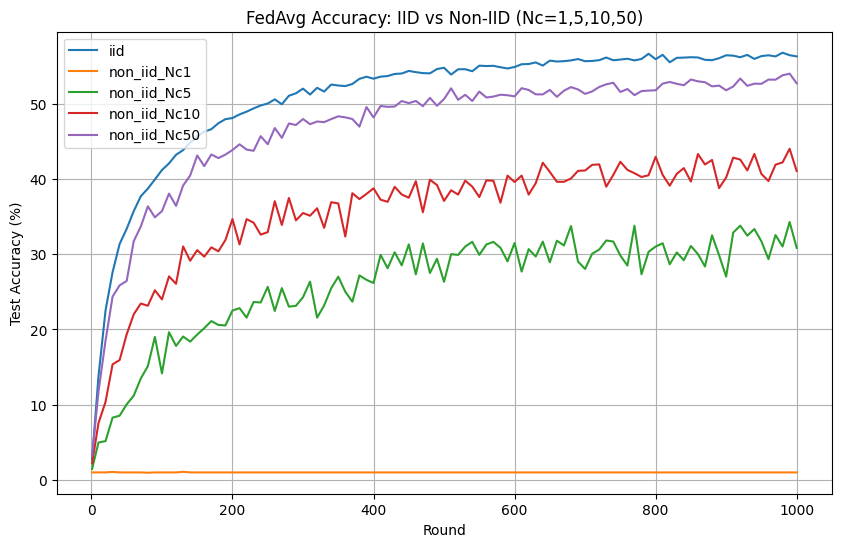

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import copy
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# If you have a separate dataset_sharder.py, import it here:
# from dataset_sharder import DatasetSharder


class EnhancedLeNet(nn.Module):
    def __init__(self):
        super(EnhancedLeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 384)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(384, 192)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x



class FedAvg:
    def __init__(self, config, model, client_datasets, test_loader):
        self.config = config
        self.global_model = model
        self.client_datasets = client_datasets
        self.test_loader = test_loader
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.global_model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.num_clients = config['num_clients']

    def client_update(self, client_model, optimizer, train_loader):
        client_model.train()
        for epoch in range(self.config['local_epochs']):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = client_model(data)
                loss = self.criterion(output, target)
                loss.backward()
                optimizer.step()
        return client_model.state_dict()

    def aggregate(self, client_weights):
        global_weights = copy.deepcopy(client_weights[0])
        for key in global_weights.keys():
            for i in range(1, len(client_weights)):
                global_weights[key] += client_weights[i][key]
            global_weights[key] = torch.div(global_weights[key], len(client_weights))
        return global_weights

    def test(self):
        """Returns only test accuracy (no test loss is tracked)."""
        self.global_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                outputs = self.global_model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = 100.0 * correct / total
        return accuracy  # Not returning loss anymore

    def run(self):
        """Trains for config['rounds'], returning only accuracies + rounds_list."""
        num_selected = max(1, int(self.config['client_fraction'] * self.num_clients))
        test_accuracies = []
        rounds_list = []

        for round_ in tqdm(range(self.config['rounds']), desc="Federated Training Rounds"):
            # 1) Randomly select a subset of clients
            selected_clients = random.sample(range(self.num_clients), num_selected)
            client_weights = []

            # 2) Each selected client trains locally
            for client_idx in selected_clients:
                local_model = copy.deepcopy(self.global_model)
                local_model.to(self.device)
                optimizer = optim.SGD(local_model.parameters(),
                                      lr=self.config['lr'],
                                      momentum=0.9,
                                      weight_decay=0.0004)

                client_dataset = self.client_datasets[client_idx]
                train_loader = DataLoader(
                    client_dataset,
                    batch_size=self.config['batch_size'],
                    shuffle=True
                )

                local_weights = self.client_update(local_model, optimizer, train_loader)
                client_weights.append(local_weights)

            # 3) Aggregate local updates => new global model
            global_weights = self.aggregate(client_weights)
            self.global_model.load_state_dict(global_weights)

            # 4) Evaluate every 'test_freq' rounds (or round 0)
            if (round_ + 1) % self.config['test_freq'] == 0 or round_ == 0:
                accuracy = self.test()
                test_accuracies.append(accuracy)
                rounds_list.append(round_ + 1)
                print(f"Round {round_+1} => Test Accuracy: {accuracy:.2f}%")

        return test_accuracies, rounds_list


def main():
    # Hyperparameters
    K = 100
    C = 0.1
    N = 1000  # total rounds
    J = 8   # local epochs
    lr = 0.01
    B = 64
    test_freq = 10

    random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load CIFAR-100
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4865, 0.4409),
                             (0.2673, 0.2564, 0.2761))
    ])

    trainset = datasets.CIFAR100(root='./data', train=True,
                                 download=True, transform=transform_train)
    testset = datasets.CIFAR100(root='./data', train=False,
                                download=True, transform=transform_test)
    test_loader = DataLoader(testset, batch_size=B, shuffle=False, num_workers=2)



    # Example non-IID scenario (n_labels=5) plus IID scenario:
    scenarios = [
        ('iid', None),
        ('non_iid', 1),
        ('non_iid', 5),
        ('non_iid', 10),
        ('non_iid', 50)
    ]

    def run_fedavg(shard_type, n_labels=5):
        # Build the client datasets
        sharder = DatasetSharder(trainset, K=K, shard_type=shard_type, n_labels=n_labels)
        client_datasets = sharder.shard_dataset()

        # FedAvg config
        fed_config = {
            'num_clients': K,
            'client_fraction': C,
            'rounds': N,
            'local_epochs': J,
            'lr': lr,
            'batch_size': B,
            'test_freq': test_freq
        }

        global_model = EnhancedLeNet().to(device)
        fedavg = FedAvg(fed_config, global_model, client_datasets, test_loader)

        scenario_name = shard_type if shard_type == 'iid' else f"non_iid_{n_labels}"
        print(f"\n--- Shard config: {scenario_name} ---")
        test_accs, rounds_list = fedavg.run()
        return test_accs, rounds_list

    # Collect results
    all_accuracies = {}
    all_rounds = {}

    for (typ, nl) in scenarios:
        scenario_key = typ if typ == 'iid' else f"non_iid_Nc{nl}"
        if typ == 'iid':
            test_accs, rounds_list = run_fedavg('iid')
        else:
            test_accs, rounds_list = run_fedavg('non_iid', n_labels=nl)

        all_accuracies[scenario_key] = test_accs
        all_rounds[scenario_key] = rounds_list

    # Plot in high quality
    plt.figure(figsize=(10, 6))  # bigger figure
    for scenario_name in all_accuracies:
        plt.plot(all_rounds[scenario_name], all_accuracies[scenario_name], label=scenario_name)

    plt.title("FedAvg Accuracy: IID vs Non-IID (Nc=1,5,10,50)")
    plt.xlabel("Round")
    plt.ylabel("Test Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Use high DPI for clearer image in LaTeX
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    fname = f"comparison_{timestamp}.png"
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to {fname}")
    plt.show()


if __name__ == "__main__":
    main()
